# Install VGGFACE

In [ ]:
pip install keras_vggface

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Augment

In [ ]:
from imgaug import augmenters as iaa
from imgaug import seed
def aug_training_set_loader(images,labels,inp_dims):
    NUM_COPIES = ceil(1000/len(images))
    images = np.array(images)
    images=augment(inp_dims[0], inp_dims[1], images, NUM_COPIES)
    aug_labels =[]
    for x in labels:
        for i in range(NUM_COPIES+1):  # NUM_COPIES+1-> numbers of augmentations + 1 original
            aug_labels.append(x)
    images, labels = skshuffle(images, aug_labels)
    # images = np.array(images)
    images = np.array(images, dtype="float") / 255.0
    labels = np.array(labels)
    return images, labels

def augment(width, height, data, NUM_COPIES):
    """
    preform augmentetion on the list of photos named 'data'
    :param width: width of a single photo
    :param height: height of a single photo
    :param data: a list of photos to augment
    :param NUM_COPIES: number of copies produced from the image
    :return: a list of photos that consists from the original photos and their augmentations
    """
    augmented_data = []
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential([
        sometimes(iaa.Sharpen(alpha=(0.0, 1.0), lightness=(0.75, 2.0))),
        sometimes(iaa.Fliplr()),  # horizontal flips
        sometimes(iaa.AddElementwise((-50, 50))),
        sometimes(iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0.0, 2.0)))),
        sometimes(iaa.ContrastNormalization((0.8, 1.2))),
        sometimes(iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            shear=(-8, 8)
        )),
        sometimes(iaa.Superpixels(p_replace=0.1, n_segments=150))
    ], random_order=True)  # apply augmenters in random order
    for img in data:
        copies = augment_image(width, height, img, seq, NUM_COPIES)
        copies.append(img.reshape(width, height, 3))
        for cpy in copies:
            augmented_data.append(cpy)
    return augmented_data


def augment_image(width, height, image, seq, NUM_COPIES):
    """
        augments a single image
    :param width: width of the image
    :param height: height of the image
    :param image: a matrix representing a rgb image
    :param seq: the augmantation sequence preformed
    :param NUM_COPIES: number of copies produced from the image
    :return: a list of all images made from 'image' not including the original
    """
    seed (1)
    copies = []
    image = image.reshape(width, height, 3)
    for i in range(NUM_COPIES):
        copies.append(seq.augment_image(image))

    return copies

# Crop

In [ ]:
import dlib

import os
import sys
import cv2
import glob


def align_and_crop(detector, im_to_align, predictor_path):
    '''
    simply aligns the photo (using the detector to identify the eyes) and crops the face.
    :param im_to_align: an address of an image
    '''

    # a shape predictor to find face landmarks so we can precisely localize the face
    sp = dlib.shape_predictor(predictor_path)

    # Ask the detector to find the bounding boxes of each face. The 1 in the
    # second argument indicates that we should upsample the image 1 time.
    try:
        dets = detector(im_to_align, 1)
    except RuntimeError:
        return -1

    num_faces = len(dets)
    if num_faces == 0:
        return im_to_align, False

    # Find the 5 face landmarks we need to do the alignment.
    faces = dlib.full_object_detections()
    for detection in dets:
        faces.append(sp(im_to_align, detection))

    # get a single chip (aligned and cropped)
    image = dlib.get_face_chip(im_to_align, faces[0])
    # cv2.imshow("f", image) show image for testing
    return image, True

# Build Models

In [ ]:
import random
import numpy as np
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense,Reshape
from keras.layers import BatchNormalization, Activation, Dropout
# from keras_vggface.vggface import VGGFace
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
from keras_vggface.vggface import VGGFace


def build_embedding(param, inp):
    network = eval('VGGFace')
    base = network(weights = 'vggface', include_top = False)
    # base = network(weights = 'imagenet', include_top = False)
    feat = base(inp)
    print(feat.shape)
    flat = Flatten()(feat)
    return flat

def build_classifier(param, embedding):
    flat = Flatten()(embedding.output)

    dense1 = Dense(400, name = 'class_dense1')(flat)
    bn1 = BatchNormalization(name = 'class_bn1')(dense1)
    act1 = Activation('relu', name = 'class_act1')(bn1)
    drop2 = Dropout(param["drop_classifier"], name = 'class_drop1')(act1)

    dense2 = Dense(100, name = 'class_dense2')(drop2)
    bn2 = BatchNormalization(name = 'class_bn2')(dense2)
    act2 = Activation('relu', name = 'class_act2')(bn2)
    drop2 = Dropout(param["drop_classifier"], name = 'class_drop2')(act2)
    
    densel = Dense(param["number_of_classe"], name = 'class_dense_last')(drop2)
    bnl = BatchNormalization(name = 'class_bn_last')(densel)
    actl = Activation('softmax', name = 'class_act_last')(bnl)
    return Model(input=embedding, outputs=actl)

def build_discriminator(param, embedding):
    embedding = Input( embedding_shape )
    flat = Flatten()(embedding)
    dense1 = Dense(400, name = 'dis_dense1')(flat)
    bn1 = BatchNormalization(name='dis_bn1')(dense1)
    act1 = Activation('relu', name = 'dis_act1')(bn1)
    drop1 = Dropout(param["drop_discriminator"], name = 'dis_drop1')(act1)

    dense2 = Dense(100, name = 'dis_dense2')(drop1)
    bn2 = BatchNormalization(name='dis_bn2')(dense2)
    act2 = Activation('relu', name = 'dis_act2')(bn2)
    drop2 = Dropout(param["drop_discriminator"], name = 'dis_drop2')(act2)

    densel = Dense(1, name = 'dis_dense_last')(drop2)
    bnl = BatchNormalization(name = 'dis_bn_last')(densel)
    actl = Activation('sigmoid', name = 'dis_act_last')(bnl)
    return Model(input=embedding, outputs=actl)

def build_combined_classifier(inp, classifier):
    comb_model = Model(inputs = inp, outputs = [classifier])
    return comb_model

def build_combined_discriminator(inp, discriminator):
    comb_model = Model(inputs = inp, outputs = [discriminator])
    return comb_model

def build_combined_model(inp, comb):
    comb_model = Model(inputs = inp, outputs = comb)
    return comb_model

Using TensorFlow backend.


# Optimizer

In [ ]:
import numpy as np
from keras.optimizers import Adam

def opt_classifier(param):
    return Adam(lr=param["lr_classifier"], beta_1=param["b1_classifier"], beta_2=param["b2_classifier"])

def opt_discriminator(param):
    return Adam(lr=param["lr_discriminator"], beta_1=param["b1_discriminator"], beta_2=param["b2_discriminator"])

def opt_combined(param):
    return Adam(lr=param["lr_combined"], beta_1=param["b1_combined"], beta_2=param["b2_combined"])


# Load Data

In [ ]:
SEED = 7
import os
import sys
import argparse
import random
import numpy as np
from tensorflow.compat.v1 import set_random_seed
from sklearn.model_selection import train_test_split
from sklearn import metrics
from plotnine import *
import pandas as pd
                
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import ceil
from sklearn.utils import shuffle as skshuffle

from imutils import paths
from sklearn.preprocessing import LabelEncoder

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
random.seed(SEED)

from PIL import Image
from keras.utils import to_categorical
from keras.layers import Input
from keras.optimizers import Adam
from keras.utils import multi_gpu_model
from sklearn.metrics import accuracy_score


def pil_loader(path):
    # Return the RGB variant of input image
    with open(path, 'rb') as f:
      with Image.open(f) as img:
        return img.convert('RGB')

def one_hot_encoding(param):
    lb = LabelEncoder()
    source_labels,target_labels  = lb.fit_transform( param["source_label"]),lb.fit_transform( param["target_label"])
    param["number_of_classe"] = len(lb.classes_)
    source_labels,target_labels = to_categorical(source_labels),to_categorical(target_labels)
    return source_labels,target_labels
            
def data_loader(filepath, inp_dims):
    # Load images and corresponding labels from the text file, stack them in numpy arrays and return
    img = []
    label = []
    detector = dlib.get_frontal_face_detector()
    predictor = "drive/My Drive/final_proj_dataset/shape_predictor_5_face_landmarks.dat"
    # grab the image paths
    imagePaths = sorted(list(paths.list_images(filepath)))
    print(imagePaths)
    # loop over the input images
    for imagePath in imagePaths:
        # extract the class label from the image path and update the
        # labels list
        l = imagePath.split(os.path.sep)[-2]
        label.append(l)
        i = pil_loader(imagePath)
        i = i.resize((inp_dims[0], inp_dims[1]), Image.ANTIALIAS)
        frame_1 = align_and_crop(detector, np.array(i), predictor)[0]
        frame_1 = cv2.resize(frame_1,(inp_dims[0], inp_dims[1]))
        img.append(frame_1)
    img = np.array(img)
    label = np.array(label)
    return img, label
    

def batch_generator(data, batch_size):
    #Generate batches of data.
    all_examples_indices = len(data[0])
    while True:
        mini_batch_indices = np.random.choice(all_examples_indices, size = batch_size, replace = False)
        tbr = [k[mini_batch_indices] for k in data]
        yield tbr


In [ ]:
def train(param):
    models = {}
    inp = Input(shape = (param["inp_dims"]))
    embedding = build_embedding(param, inp) 
    # embedding = build_embedding(param)   
    
    # Build and compile the discriminator
    discriminator = build_discriminator(param, embedding)

    # The discriminator takes the representaton as input and determines the domain
    models["combined_discriminator"] = Model(inputs=inp, outputs=discriminator(embedding))
    models["combined_discriminator"].compile(optimizer = opt_discriminator(param), loss = 'binary_crossentropy', metrics = ['accuracy'])
    # For the combined model we will only train the generator
    discriminator.trainable = False
  
    # # Build the classifier
    classifier = build_classifier(param, embedding)
    models['combined_classifier'] = Model(inputs=inp, outputs=classifier(embedding))
    models["combined_classifier"].compile(optimizer = opt_classifier(param), loss = 'categorical_crossentropy', metrics = ['accuracy'])
   
    models["combined_model"] = build_combined_model(inp, [classifier(embedding), discriminator(embedding)]) 
    models["combined_model"].compile(optimizer = opt_combined(param), loss = ['categorical_crossentropy', 'binary_crossentropy'] , loss_weights =  [param["class_loss_weight"],  param["dis_loss_weight"]], metrics = ['accuracy'])

    models["combined_classifier"].summary()
    models["combined_discriminator"].summary()
    models["combined_model"].summary()

    Xs, ys = param["source_data"], param["source_label"]
    Xt, yt = param["target_data"], param["target_label"]

    Xt, Xt_test, yt, yt_test = train_test_split(Xt, yt, test_size=0.2, random_state=42)
    Xs, Xs_test, ys, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)
    
    Xs, ys = aug_training_set_loader(Xs, ys, param["inp_dims"])
    Xt, yt = aug_training_set_loader(Xt, yt, param["inp_dims"])

    # Source domain is represented by label 0 and Target by 1
    ys_adv = np.array(([0.] * ys.shape[0]))
    yt_adv = np.array(([1.] * yt.shape[0]))

    y_advb_1 = np.array(([1] * param["batch_size"] + [0] * param["batch_size"])) # For gradient reversal
    y_advb_2 = np.array(([0] * param["batch_size"] + [1] * param["batch_size"]))
    weight_class = np.array(([1] * param["batch_size"] + [0] * param["batch_size"]))
    weight_adv = np.ones((param["batch_size"] * 2,))
    S_batches = batch_generator([Xs, ys], param["batch_size"])
    T_batches = batch_generator([Xt, np.zeros(shape = (len(Xt),))], param["batch_size"])

    param["target_accuracy"] = 0

    optim = {}
    optim["iter"] = 0
    optim["acc"] = ""
    optim["labels"] = np.array(Xt.shape[0],)
    gap_last_snap = 0

    acc_source=[]
    acc_target=[]
    acc_domain_source=[]
    acc_domain_target=[]
    loss_discriminator = []
    loss_classifier_source=[]

    t_domain_label = np.ones(( param["batch_size"], 1))
    s_domain_label = np.zeros(( param["batch_size"], 1))
    for i in range(param["num_iterations"]):        
        Xsb, ysb = next(S_batches)
        Xtb, ytb = next(T_batches)
        X_adv = np.concatenate([Xsb, Xtb])
        y_class = np.concatenate([ysb, np.zeros_like(ysb)])

        d_loss = models["combined_discriminator"].train_on_batch(X_adv, [y_advb_2])

        # Train the generator (wants discriminator to mistake images as real)
        g_loss_s = models["combined_model"].train_on_batch(X_adv, [y_class, y_advb_1])

        if ((i + 1) % param["test_interval"] == 0):
            ys_pred = models["combined_classifier"].predict(Xs)
            yt_pred = models["combined_classifier"].predict(Xt)
            
            ys_adv_pred = models["combined_discriminator"].predict(Xs)
            yt_adv_pred = models["combined_discriminator"].predict(Xt)

            source_accuracy = accuracy_score(ys.argmax(1), ys_pred.argmax(1))              
            target_accuracy = accuracy_score(yt.argmax(1), yt_pred.argmax(1))
            source_domain_accuracy = accuracy_score(ys_adv, np.round(ys_adv_pred))              
            target_domain_accuracy = accuracy_score(yt_adv, np.round(yt_adv_pred))

            acc_source.append(source_accuracy)
            acc_target.append(target_accuracy)
            acc_domain_source.append(source_domain_accuracy)
            acc_domain_target.append(target_domain_accuracy)

            loss_discriminator.append(d_loss[1])
            loss_classifier_source.append(g_loss[3])

            log_str = "iter: {:05d}: \nLABEL CLASSIFICATION: source_accuracy: {:.5f}, target_accuracy: {:.5f}\
                    \nDOMAIN DISCRIMINATION: source_domain_accuracy: {:.5f}, target_domain_accuracy: {:.5f} \n"\
                                                         .format(i, source_accuracy*100, target_accuracy*100,
                                                      source_domain_accuracy*100, target_domain_accuracy*100)
            print(log_str)

            if param["target_accuracy"] < target_accuracy:              
                optim["iter"] = i
                optim["acc"] = log_str
                optim["labels"] = ys_pred.argmax(1)
                param["target_accuracy"] = target_accuracy
    
    print(optim["iter"],optim["acc"],optim["labels"])

    print("Source matrix: ",metrics.confusion_matrix(ys.argmax(1), ys_pred.argmax(1)))
    print("Target matrix: ",metrics.confusion_matrix(yt.argmax(1), yt_pred.argmax(1)))

    ys_test_pred = models["combined_classifier"].predict(Xs_test)
    yt_test_pred = models["combined_classifier"].predict(Xt_test)
    source_accuracy_test = accuracy_score(ys_test.argmax(1), ys_test_pred.argmax(1))              
    target_accuracy_test = accuracy_score(yt_test.argmax(1), yt_test_pred.argmax(1))

    print("source accuracy test",source_accuracy_test)
    print("target accuracy test",target_accuracy_test)

    print("Source matrix: ",metrics.confusion_matrix(ys_test.argmax(1), ys_test_pred.argmax(1)))
    print("Target matrix: ",metrics.confusion_matrix(yt_test.argmax(1), yt_test_pred.argmax(1)))

    N = np.arange(0,len(acc_source))

    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, np.array(acc_source), label="Source accuracy")
    plt.plot(N, np.array(acc_target), label="Target accuracy")
    plt.plot(N, np.array(acc_domain_source), label="Domain Source accuracy")
    plt.plot(N, np.array(acc_domain_target), label="Domain Target accuracy")
    plt.title("Training Accuracy of Source and Target ")
    plt.xlabel("Number of intervals")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, np.array(loss_classifier_source), label="Classifier Loss")
    plt.plot(N, np.array(loss_discriminator), label="Discriminator loss")
    plt.title("Training Loss of Source and Target ")
    plt.xlabel("Number of intervals")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()



# Main

In [ ]:
import argparse
if __name__ == "__main__":
    # Initialize parameters
    param = {}
    param["number_of_gpus"] = 1
    param["network_name"] = 'VGGFace'
    param["inp_dims"] = [224, 224, 3]
    param["num_iterations"] = 2000
    param["lr_classifier"] = 0.0001
    param["b1_classifier"] = 0.9
    param["b2_classifier"] = 0.999    
    param["lr_discriminator"] = 0.00001
    param["b1_discriminator"] =  0.9
    param["b2_discriminator"] = 0.999
    param["lr_combined"] = 0.00001
    param["b1_combined"] =  0.9
    param["b2_combined"] =  0.999       
    param["batch_size"] = int(32/2)
    param["class_loss_weight"] = 1
    param["dis_loss_weight"] = 4    
    param["drop_classifier"] = 0.25
    param["drop_discriminator"] = 0.25
    param["test_interval"] = 100
    param["source_path"] = 'drive/My Drive/pro_data/dataset_shelly'
    param["target_path"] = 'drive/My Drive/pro_data/dataset_yerus' 
    param["snapshot_interval"] = 500
    param["output_path"] = 'drive/My Drive/final_proj_dataset/result2'
    param["number_of_classe"] = 0

    # # Create directory for saving models and log files
    if not os.path.exists(param["output_path"]):
        os.mkdir(param["output_path"])
  
   

In [ ]:
print("[INFO] loading images...")
# Load source and target data
param["source_data"], param["source_label"] = data_loader(param["source_path"], param["inp_dims"])
print("source images loaded")
param["target_data"], param["target_label"] = data_loader(param["target_path"], param["inp_dims"])
print("target images loaded")
# Encode labels into one-hot format
print("[INFO] Encode labels into one-hot format")
param["source_label"], param["target_label"] = one_hot_encoding(param)

[INFO] loading images...
source images loaded
target images loaded
[INFO] Encode labels into one-hot format


[INFO] training network...
(None, 7, 7, 512)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("di..., inputs=Tensor("in...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("cl..., inputs=Tensor("in...)`


Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
vggface_vgg16 (Model)        multiple                  14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 25088)             0         
_________________________________________________________________
model_37 (Model)             multiple                  10077910  
Total params: 24,792,598
Trainable params: 24,791,594
Non-trainable params: 1,004
_________________________________________________________________
Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 224, 224, 3)       0         
________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


iter: 00099: 
LABEL CLASSIFICATION: source_accuracy: 83.00493, target_accuracy: 42.77504                    
DOMAIN DISCRIMINATION: source_domain_accuracy: 97.86535, target_domain_accuracy: 18.39080 

iter: 00199: 
LABEL CLASSIFICATION: source_accuracy: 85.96059, target_accuracy: 29.47455                    
DOMAIN DISCRIMINATION: source_domain_accuracy: 87.60263, target_domain_accuracy: 2.62726 

iter: 00299: 
LABEL CLASSIFICATION: source_accuracy: 88.58785, target_accuracy: 31.03448                    
DOMAIN DISCRIMINATION: source_domain_accuracy: 78.81773, target_domain_accuracy: 0.49261 

iter: 00399: 
LABEL CLASSIFICATION: source_accuracy: 92.11823, target_accuracy: 41.05090                    
DOMAIN DISCRIMINATION: source_domain_accuracy: 67.24138, target_domain_accuracy: 1.39573 

iter: 00499: 
LABEL CLASSIFICATION: source_accuracy: 92.69294, target_accuracy: 42.28243                    
DOMAIN DISCRIMINATION: source_domain_accuracy: 55.82923, target_domain_accuracy: 6.07553 


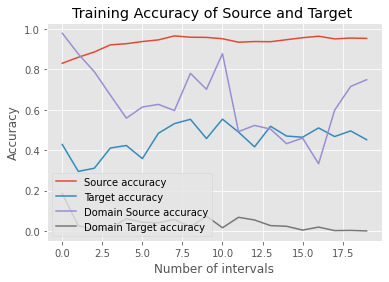

In [ ]:
# Train data
print("[INFO] training network...")
train(param)

# Load model

In [ ]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model

model_path = 'drive/My Drive/final_proj_dataset/result2/model.h5'
# load model
model = load_model(model_path)
# summarize model.
model.summary()
# load dataset

score_Target = model.evaluate(Xs_test, ys_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
vggface_vgg16 (Model)        multiple                  14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
class_dense1 (Dense)         (None, 400)               10035600  
_________________________________________________________________
class_bn1 (BatchNormalizatio (None, 400)               1600      
_________________________________________________________________
class_act1 (Activation)      (None, 400)               0         
_________________________________________________________________
class_drop1 (Dropout)        (None, 400)               0   

NameError: ignored

# Only Classifier

In [ ]:

from keras_vggface.vggface import VGGFace

def build_embedding_vgg(param, inp):
    network = eval('VGGFace')
    base = network(weights = 'vggface', include_top = False)
    feat = base(inp)
    flat = Flatten()(feat)
    return flat

def build_classifier_vgg(param, embedding):
    dense1 = Dense(400, name = 'class_dense1')(embedding)
    bn1 = BatchNormalization(name = 'class_bn1')(dense1)
    act1 = Activation('relu', name = 'class_act1')(bn1)
    drop2 = Dropout(param["drop_classifier"], name = 'class_drop1')(act1)

    dense2 = Dense(100, name = 'class_dense2')(drop2)
    bn2 = BatchNormalization(name = 'class_bn2')(dense2)
    act2 = Activation('relu', name = 'class_act2')(bn2)
    drop2 = Dropout(param["drop_classifier"], name = 'class_drop2')(act2)

    densel = Dense(param["source_label"].shape[1], name = 'class_dense_last')(drop2)
    bnl = BatchNormalization(name = 'class_bn_last')(densel)
    actl = Activation('softmax', name = 'class_act_last')(bnl)
    return actl


def train_classifier(param):
    models = {}
    inp = Input(shape = (param["inp_dims"]))
    embedding = build_embedding_vgg(param,inp)
    classifier = build_classifier_vgg(param, embedding)
    
    models["combined_classifier"] = Model(inp,classifier)
    models["combined_classifier"].compile(optimizer = opt_classifier(param), loss = 'categorical_crossentropy', metrics = ['accuracy'])


    Xs, ys = param["source_data"], param["source_label"]
    Xt, yt = param["target_data"], param["target_label"]

    Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, test_size=0.25, random_state=42)
    Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.25, random_state=42)


    S_batches = batch_generator([Xs_train, ys_train], param["batch_size"])
    T_batches = batch_generator([Xt_train, np.zeros(shape = (len(Xt_train),))], param["batch_size"])

    param["target_accuracy"] = 60

    optim = {}
    optim["iter"] = 0
    optim["acc"] = ""
    optim["labels"] = np.array(Xt.shape[0],)
    gap_last_snap = 0

    acc_source=[]
    acc_target=[]
    acc_domain_source=[]
    acc_domain_target=[]

    for i in range(param["num_iterations"]):        
        Xsb, ysb = next(S_batches)
        Xtb, ytb = next(T_batches)
 

        stats1 = models["combined_classifier"].train_on_batch(Xsb, [ysb])

        if ((i + 1) % param["test_interval"] == 0):
            ys_pred = models["combined_classifier"].predict(Xs_train)
            yt_pred = models["combined_classifier"].predict(Xt_train)


            source_accuracy = accuracy_score(ys_train.argmax(1), ys_pred.argmax(1))              
            target_accuracy = accuracy_score(yt_train.argmax(1), yt_pred.argmax(1))


            acc_source.append(source_accuracy)
            acc_target.append(target_accuracy)

            log_str = "iter: {:05d}: \nLABEL CLASSIFICATION: source_accuracy: {:.5f}, target_accuracy: {:.5f}"\
                                                         .format(i, source_accuracy*100, target_accuracy*100)
            print(log_str)

            models["combined_classifier"].save('drive/My Drive/final_proj_dataset/result2/model.h5')
            

    print("Source matrix: ",metrics.confusion_matrix(ys_train.argmax(1), ys_pred.argmax(1)))
    print("Target matrix: ",metrics.confusion_matrix(yt_train.argmax(1), yt_pred.argmax(1)))

    ys_test_pred = models["combined_classifier"].predict(Xs_test)
    yt_test_pred = models["combined_classifier"].predict(Xt_test)
    source_accuracy_test = accuracy_score(ys_test.argmax(1), ys_test_pred.argmax(1))              
    target_accuracy_test = accuracy_score(yt_test.argmax(1), yt_test_pred.argmax(1))

    print("source accuracy test",source_accuracy_test)
    print("target accuracy test",target_accuracy_test)

    print("Source matrix: ",metrics.confusion_matrix(ys_test.argmax(1), ys_test_pred.argmax(1)))
    print("Target matrix: ",metrics.confusion_matrix(yt_test.argmax(1), yt_test_pred.argmax(1)))


    N = np.arange(0,len(acc_source))

    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, np.array(acc_source), label="Source accuracy")
    plt.plot(N, np.array(acc_target), label="Target accuracy")
    plt.title("Training Accuracy of Source and Target ")
    plt.xlabel("Number of iteration")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()



(None, 7, 7, 512)
iter: 00099: 
LABEL CLASSIFICATION: source_accuracy: 100.00000, target_accuracy: 55.78947
iter: 00199: 
LABEL CLASSIFICATION: source_accuracy: 100.00000, target_accuracy: 54.21053
iter: 00299: 
LABEL CLASSIFICATION: source_accuracy: 100.00000, target_accuracy: 52.63158
iter: 00399: 
LABEL CLASSIFICATION: source_accuracy: 100.00000, target_accuracy: 53.68421
iter: 00499: 
LABEL CLASSIFICATION: source_accuracy: 100.00000, target_accuracy: 51.57895
iter: 00599: 
LABEL CLASSIFICATION: source_accuracy: 100.00000, target_accuracy: 50.52632
iter: 00699: 
LABEL CLASSIFICATION: source_accuracy: 100.00000, target_accuracy: 52.63158
iter: 00799: 
LABEL CLASSIFICATION: source_accuracy: 100.00000, target_accuracy: 50.52632
iter: 00899: 
LABEL CLASSIFICATION: source_accuracy: 100.00000, target_accuracy: 50.52632
iter: 00999: 
LABEL CLASSIFICATION: source_accuracy: 100.00000, target_accuracy: 53.68421
Source matrix:  [[95  0]
 [ 0 95]]
Target matrix:  [[ 9 85]
 [ 3 93]]
source accur

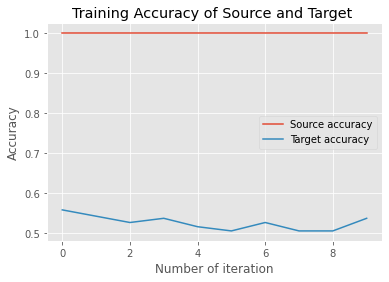

In [ ]:
train_classifier(param)